# Modelling of interventions for TB in prisons

##### Alliance meeting Paraguay EUSAT-RCS consortium, 2024

Designed by Juan F. Vesga, 2024 

During this session we will examine the impact of interventions targeted at different steps in the TB cascade of care, for a hypotehtical setting with high levels of transmission in prisons. For this purpose we will use a pre-coded TB transmission model. Our model is coded in R and all available functions are available in the folders with this notebook. The practical is designed for a wider audience (i.e, no need to be fluent in R!) and focuses on understanding TB dynamics under different interventions. Howevere, it should also be a good resource for those already fammiliar with Rvprogramming language and an introductory gate for those aiming at learning more about TB modelling in R. 

**The Model**

Take a moment to understand the model structure. If you want to explore how this model is coded in R, open the file "R/TB_prison.r" in the directory  

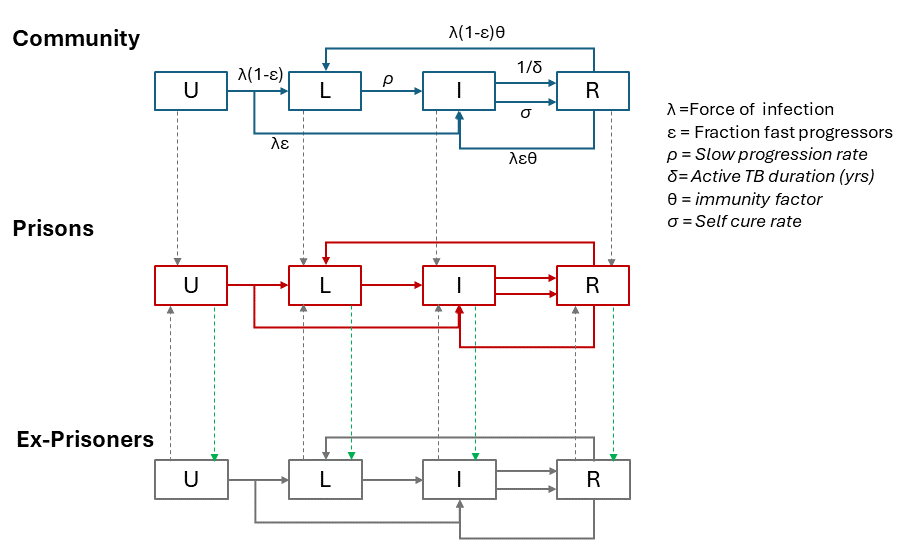

This model has three separate transmission environments: The community, prisons and Xrisioner population. The three dimensions replicate the same mechanistic approach to TB transmission. This is, uninfected individuals (U) get infected at a rate lambda which is defined by a per-capita effectve contact rate (beta) and the time vafrying prevalence of TB infectious individuals. Once infected, individuals can either mpve into the latent TB infection compartment (L) or fast-track into the active TB compartment (I). Transitions from L into I occur at a much slower rate reflecting the remote source of TB incidence known from the literature. Active TB has an average duration of 3 years, after which individuals can either die from te disease or recover. The recovered compartment (R) allows for re-infection and also relapse. The re-infection process from R is mediated by some form of immunity acquired thorugh previous infection.   

**Part I: Calibrate a baseline model**

*TB epidemiology in country "X"*

We will work under the assumption of an unidentified country "X" which is reported to have a TB burden (TB incidence) of 250 per 100,000 individuals and a TB incidence in prisons of 990 per 100,000. The imprisoned population is ~0.5% of the population, and the average sentence time is ~2.5 years. The incarceration rate has been estimated at 200 per 100,000 and is thought to be 5 five times that for re-offenders. 

An assessment of the cascade of TB care in country "X", has shown that most individuals take around 1 year between developing TB symptoms and seeking for care. Of those seeking care, ~80% get diagnosed and of those diagnosed, 89% get treated. 

Inside the prison system however, this cascade is less efficient, and it has been estimated that only 62% of cases get diagnosed and of those diagnosed, only 70% receive treatment. There is currently no preventive therapy programme in country "X".    

You will use the code available here to try and reproduce the TB burden in country "X" using the model structure detailed above. At each step you will be asked to execute 'chunks' of code. In most cases, this code will result in a new figure for you to examine. In other cases we will execute code to prepare our analysis or to load our input. 


**A)** In the code below we are going to create input parameters to our TB model. Following the description of the TB epidemic indicators in country "X", try to complete the list of parameters by entering numeric values for all the fields where you see **"??"**. Then, run the code chunk.

In [250]:
# Model Parameters
T.lfx    <- 72              # Life expectancy
T.dur    <- 3               # Duration of infectious period (years)
mu       <- 1/T.lfx         # Background mortality rate
mu_tb    <- 0.5*1/T.dur     # TB mortality rate
fast     <- 0.1             # Fraction fast progressing to active TB
imm      <- 0.5             # Infectiousness decline (partial immunity)
relapse  <- 0.005           # Relapse rate
r_incar  <- ??              # Incarceration rate
r_reincar<- 1000/1e5        # Re-Incarceration rate
r_release<- 1/2.5           # release rate (1/mean term time) 
RRc      <- 2               # Ratio of increase in contact in prison relative to community
RRbreak_p<- 1               # relative increase in TB reactivation in prison
RRbreak_x<- 2               # relative increase in TB reactivation in ex-prison
T.rTx    <- 0.5             # 6 months treatment duration
care_seeking<-1             # Careseeking rate (1 year)
care_seeking_p<-1             # Careseeking rate (1 year)
care_seeking_x<-1             # Careseeking rate (1 year)

#Community params
beta     <- 5               # Transmission rate per capita
break_in <- 0.1*1/T.lfx     # Transition rate from latent to active disease
selfcure <- 0.5*1/T.dur     # Rate of spontaneous cure
pDx  <- ??                  # Probability of being diagnosed once sought care
pTx  <- 0.89                # probability of receiving correct Tx if diagnosed

#Prison params
beta_p     <- beta*RRc           # Transmission rate per capita
break_in_p <- break_in*RRbreak_p # Transition rate from latent to active disease
fast_p     <- 0.1                # Fraction fast progressing to active TB
selfcure_p <- 0.5*1/T.dur        # Rate of spontaneous cure
pDx_p  <- 0.62                   # Probability of being diagnosed once sought care
pTx_p  <- 0.70                   # probability of receiving correct Tx if diagnosed

#Ex-Prisoners params
beta_x     <- beta               # Transmission rate per capita
break_in_x <- break_in*RRbreak_x # Transition rate from latent to active disease
selfcure_x <- 0.5*1/T.dur        # Rate of spontaneous cure
pDx_x  <- pDx                    # Probability of being diagnosed once sought care
pTx_x  <- pTx                  # probability of receiving correct Tx if diagnosed

# Initial Conditions
N  <- 1                    # Total population equal to unity 
I0 <- 1e-6                 # TB seed at time 0
Np  <- 0.005               # Total prison population (0.5% of total population) 
I0p <- Np*1e-6*10        # TB seed at time 0
Nx  <- Np*2              # Total population ex-prisioners 
I0x <- Nx*1e-6*5        # TB seed at time 0



Run the following chunk of code to load necesssary R libraries and functions for our analysis. If you have time, explore the file location *"R/TB_prison.r"* , which is where the TB model described above have been coded. We will execute this function several times during this session.   

In [251]:
# Load the R functions for TB transmission in prisons and for analysisng interventions
source("R/TB_prison.r")
source("R/useful_functions.r")

# Load necessary libraries
library(deSolve)
library(gridExtra)
library(ggplot2)
library(reshape)

Run the code chunk to simulate a TB epidemic in country X. Now that you have created your parameter inputs and loaded the necessary functions, you will see TB incidence trajectories for the three sub-populations of interest. 

But the trajectories above don't agree with the burden described before. 

**B)** Run the code chunk below once, and note that for both "Community" and "Prisoners", the plot displays a red dot which marks the estimated TB incidence per 100k according to the *TB epidemiology in country X* section above. 

**C)** Change the values for 'beta' and 'RRc' in the code below, and run until you make the simulated trajectory fit the data point. 

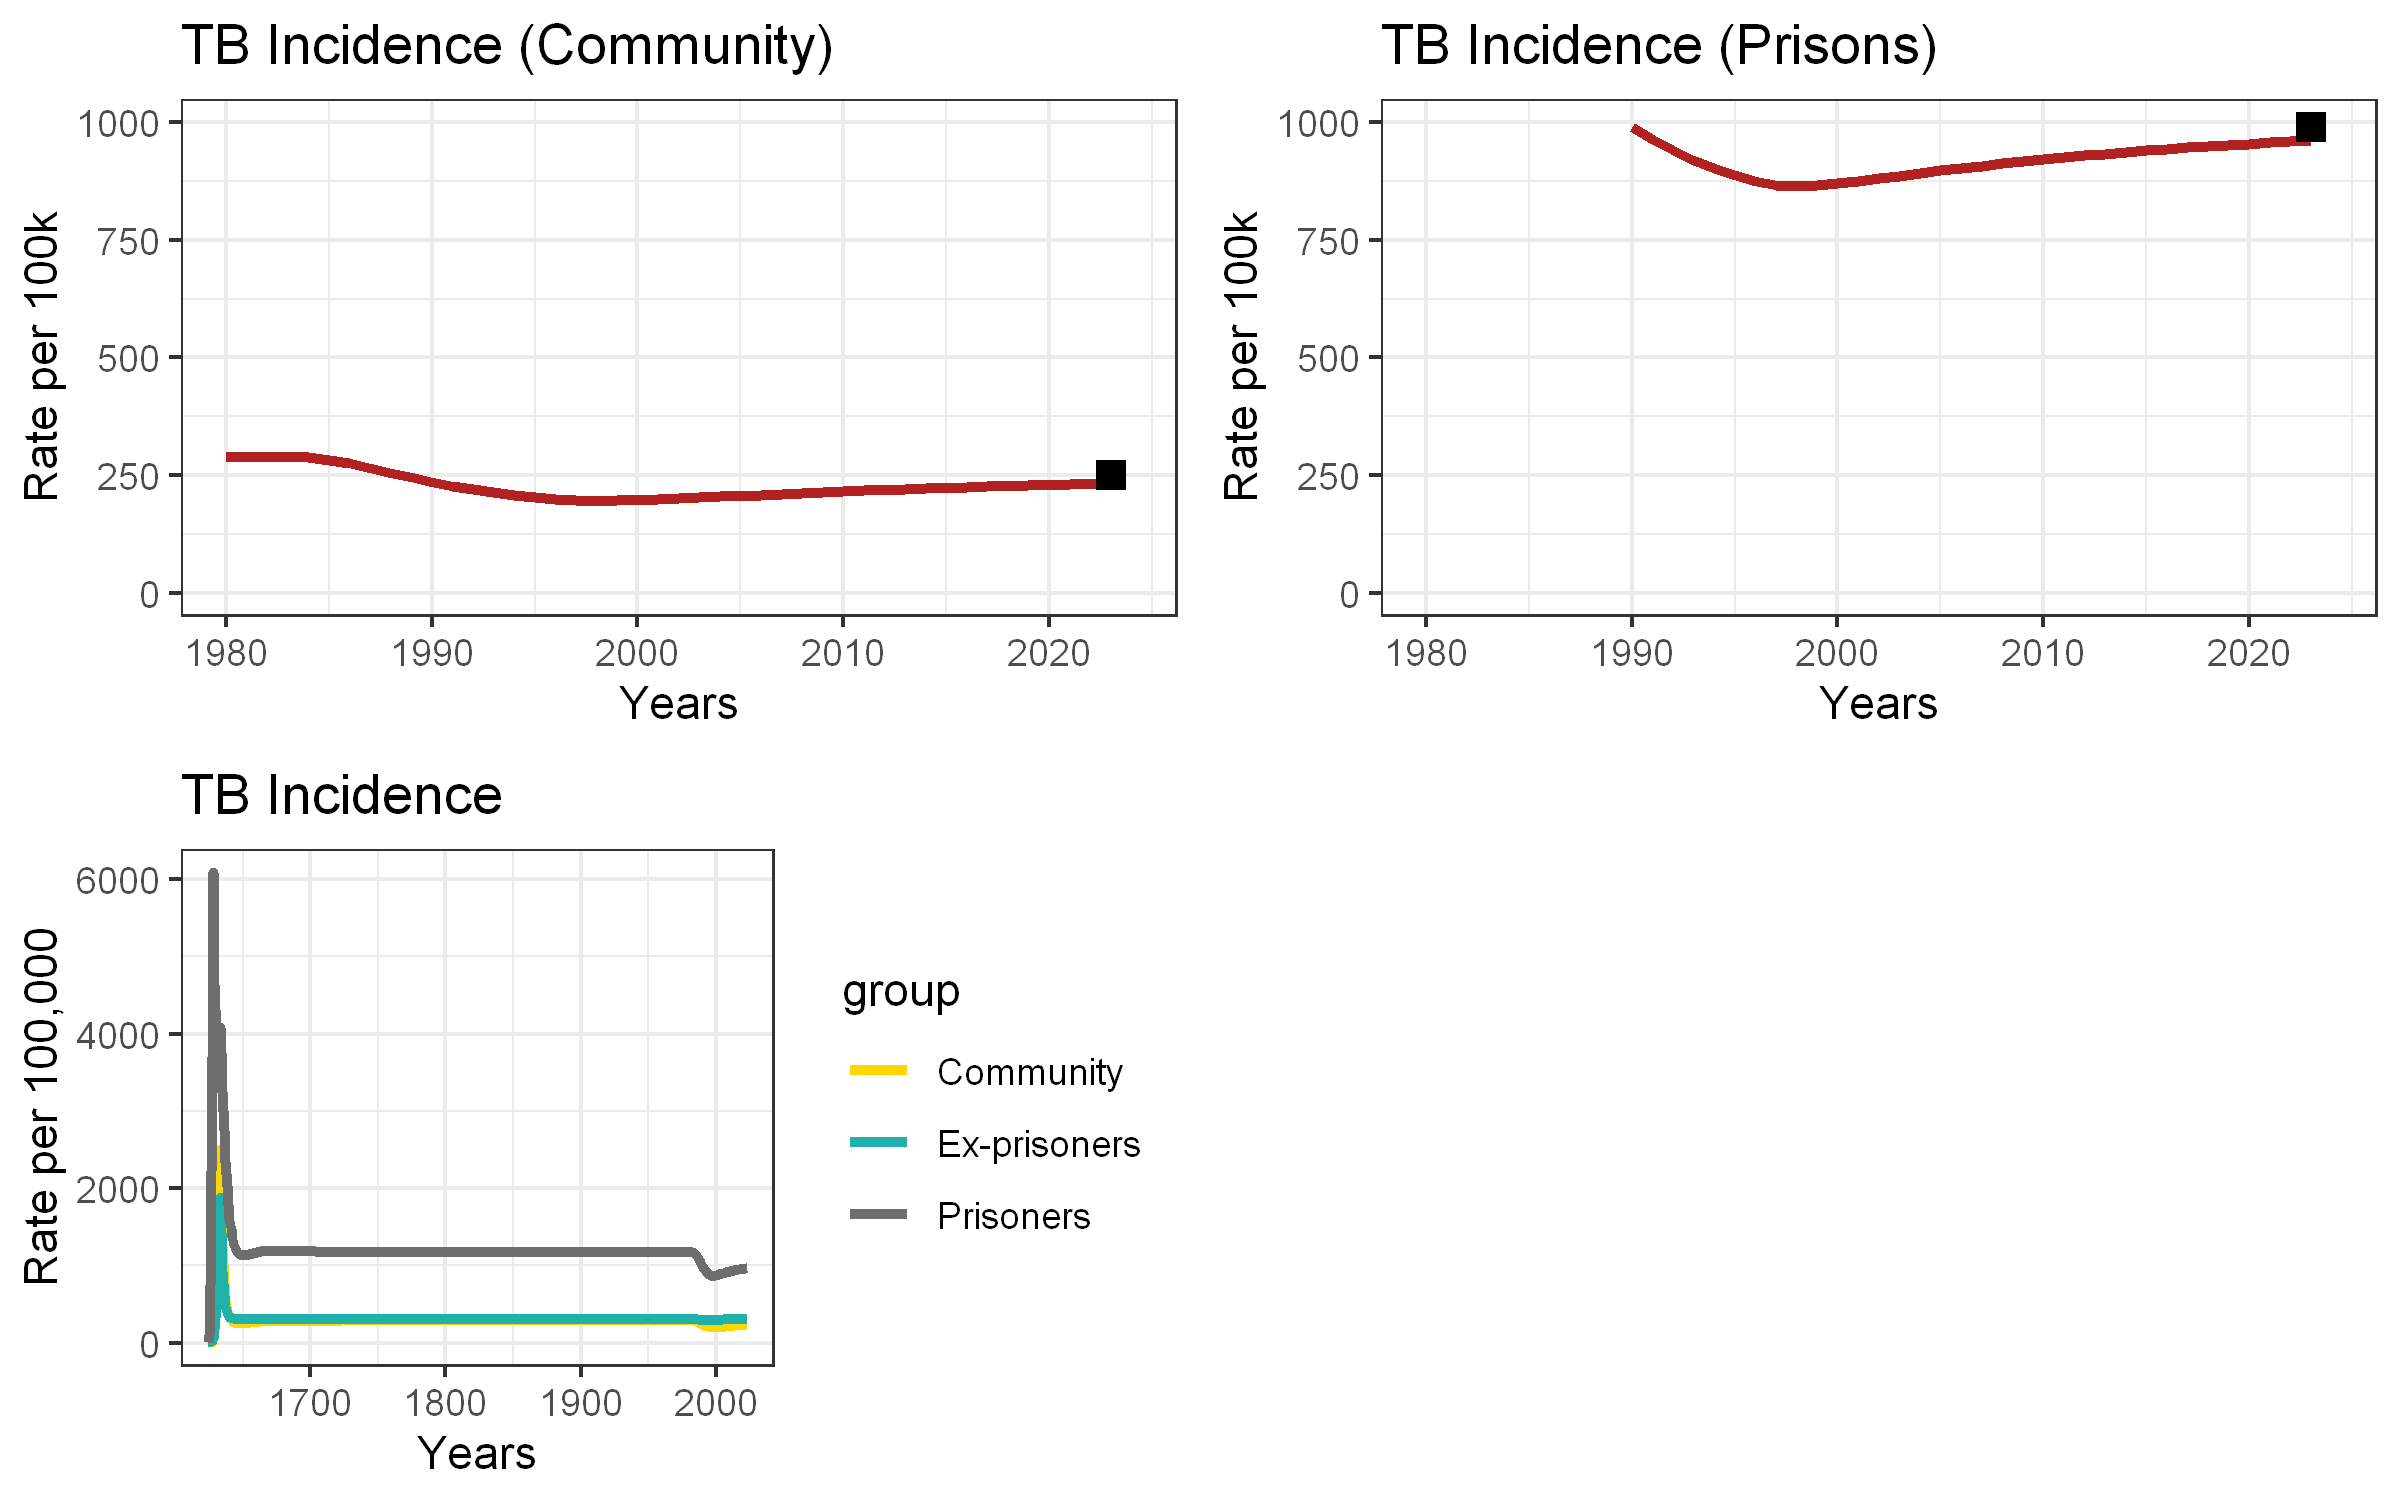

In [263]:
# Create time vectors for simulation
t.intervention <- 400      # years of simulation
t.scale        <- 3        # Scaling up time of interventions
times <- seq(0, t.intervention, by = 1)          # time scale
t.interv   <- c(t.intervention-40, (t.intervention-30)+t.scale)

# Create parameters list to pass to model function
params <- c(
  break_in = break_in,
  break_in_p = break_in_p,
  break_in_x = break_in_x,
  selfcure = selfcure, 
  selfcure_p = selfcure_p, 
  selfcure_x = selfcure_x, 
  mu = mu, 
  mu_tb = mu_tb,
  beta = beta,
  beta_p = beta_p, 
  fast = fast, 
  fast_p = fast_p, 
  imm = imm, 
  relapse = relapse,
  r_incar=r_incar,
  r_reincar=r_reincar,
  r_release=r_release) 


# Calibrate transmission parameters and 

beta     <- 7  # Transmission rate per capita in the community
RRbreak_p<- 2 # Relative increase in TB reactivation in prison
break_in_p <- break_in*RRbreak_p # Transition rate from latent to active disease
beta_p   <- beta * RRc # Transmission rate per capita in prisoners

params["beta"]<-beta
params["beta_p"]<-beta_p
params["break_in_p"]<-break_in_p

# Build baseline cascade of care 
cascade <-pDx*pTx*(1/(care_seeking+T.rTx))
cascade_x <-pDx_x*pTx_x*(1/(care_seeking+T.rTx))
cascade_p <-pDx_p*pTx_p*(1/(care_seeking+T.rTx))

params_base<- params
params_base["selfcure"]<-selfcure + cascade
params_base["selfcure_x"]<-selfcure_x + cascade_x
params_base["selfcure_p"]<-selfcure_p + cascade_p




# Create dataframe with initial conditions (t0)
xstart <- data.frame(
  U = N-I0-Np-Nx,
  L = 0,
  I = I0,  
  R = 0,
  Ux = Nx-I0x,
  Lx = 0,
  Ix = I0x,  
  Rx = 0,
  Up = Np-I0p,
  Lp = 0,
  Ip = I0p,  
  Rp = 0,
  Incidence = 0, 
  Irecent = 0, 
  Iremote = 0,
  Incidence_x = 0, 
  Irecent_x = 0, 
  Iremote_x = 0,
  Incidence_p = 0, 
  Irecent_p = 0, 
  Iremote_p = 0)  


out0  <- get_intervention(xstart, 
                          params_base,
                          params, 
                          times, 
                          t.interv, 
                          "Initial", 
                          NA) 

# plot

options(repr.plot.width = 8, repr.plot.height = 5, repr.plot.res=300, warn=-1)# Plot options for this notebook(just once)
grid.arrange(out0$incbase_c, out0$incbase_p, out0$inc_all, nrow=2)

If you calibrated input parameters, now you are ready to move to part II whhere we will introduce interventions. 
Run the chunk below to see your calibrated baseline model. 

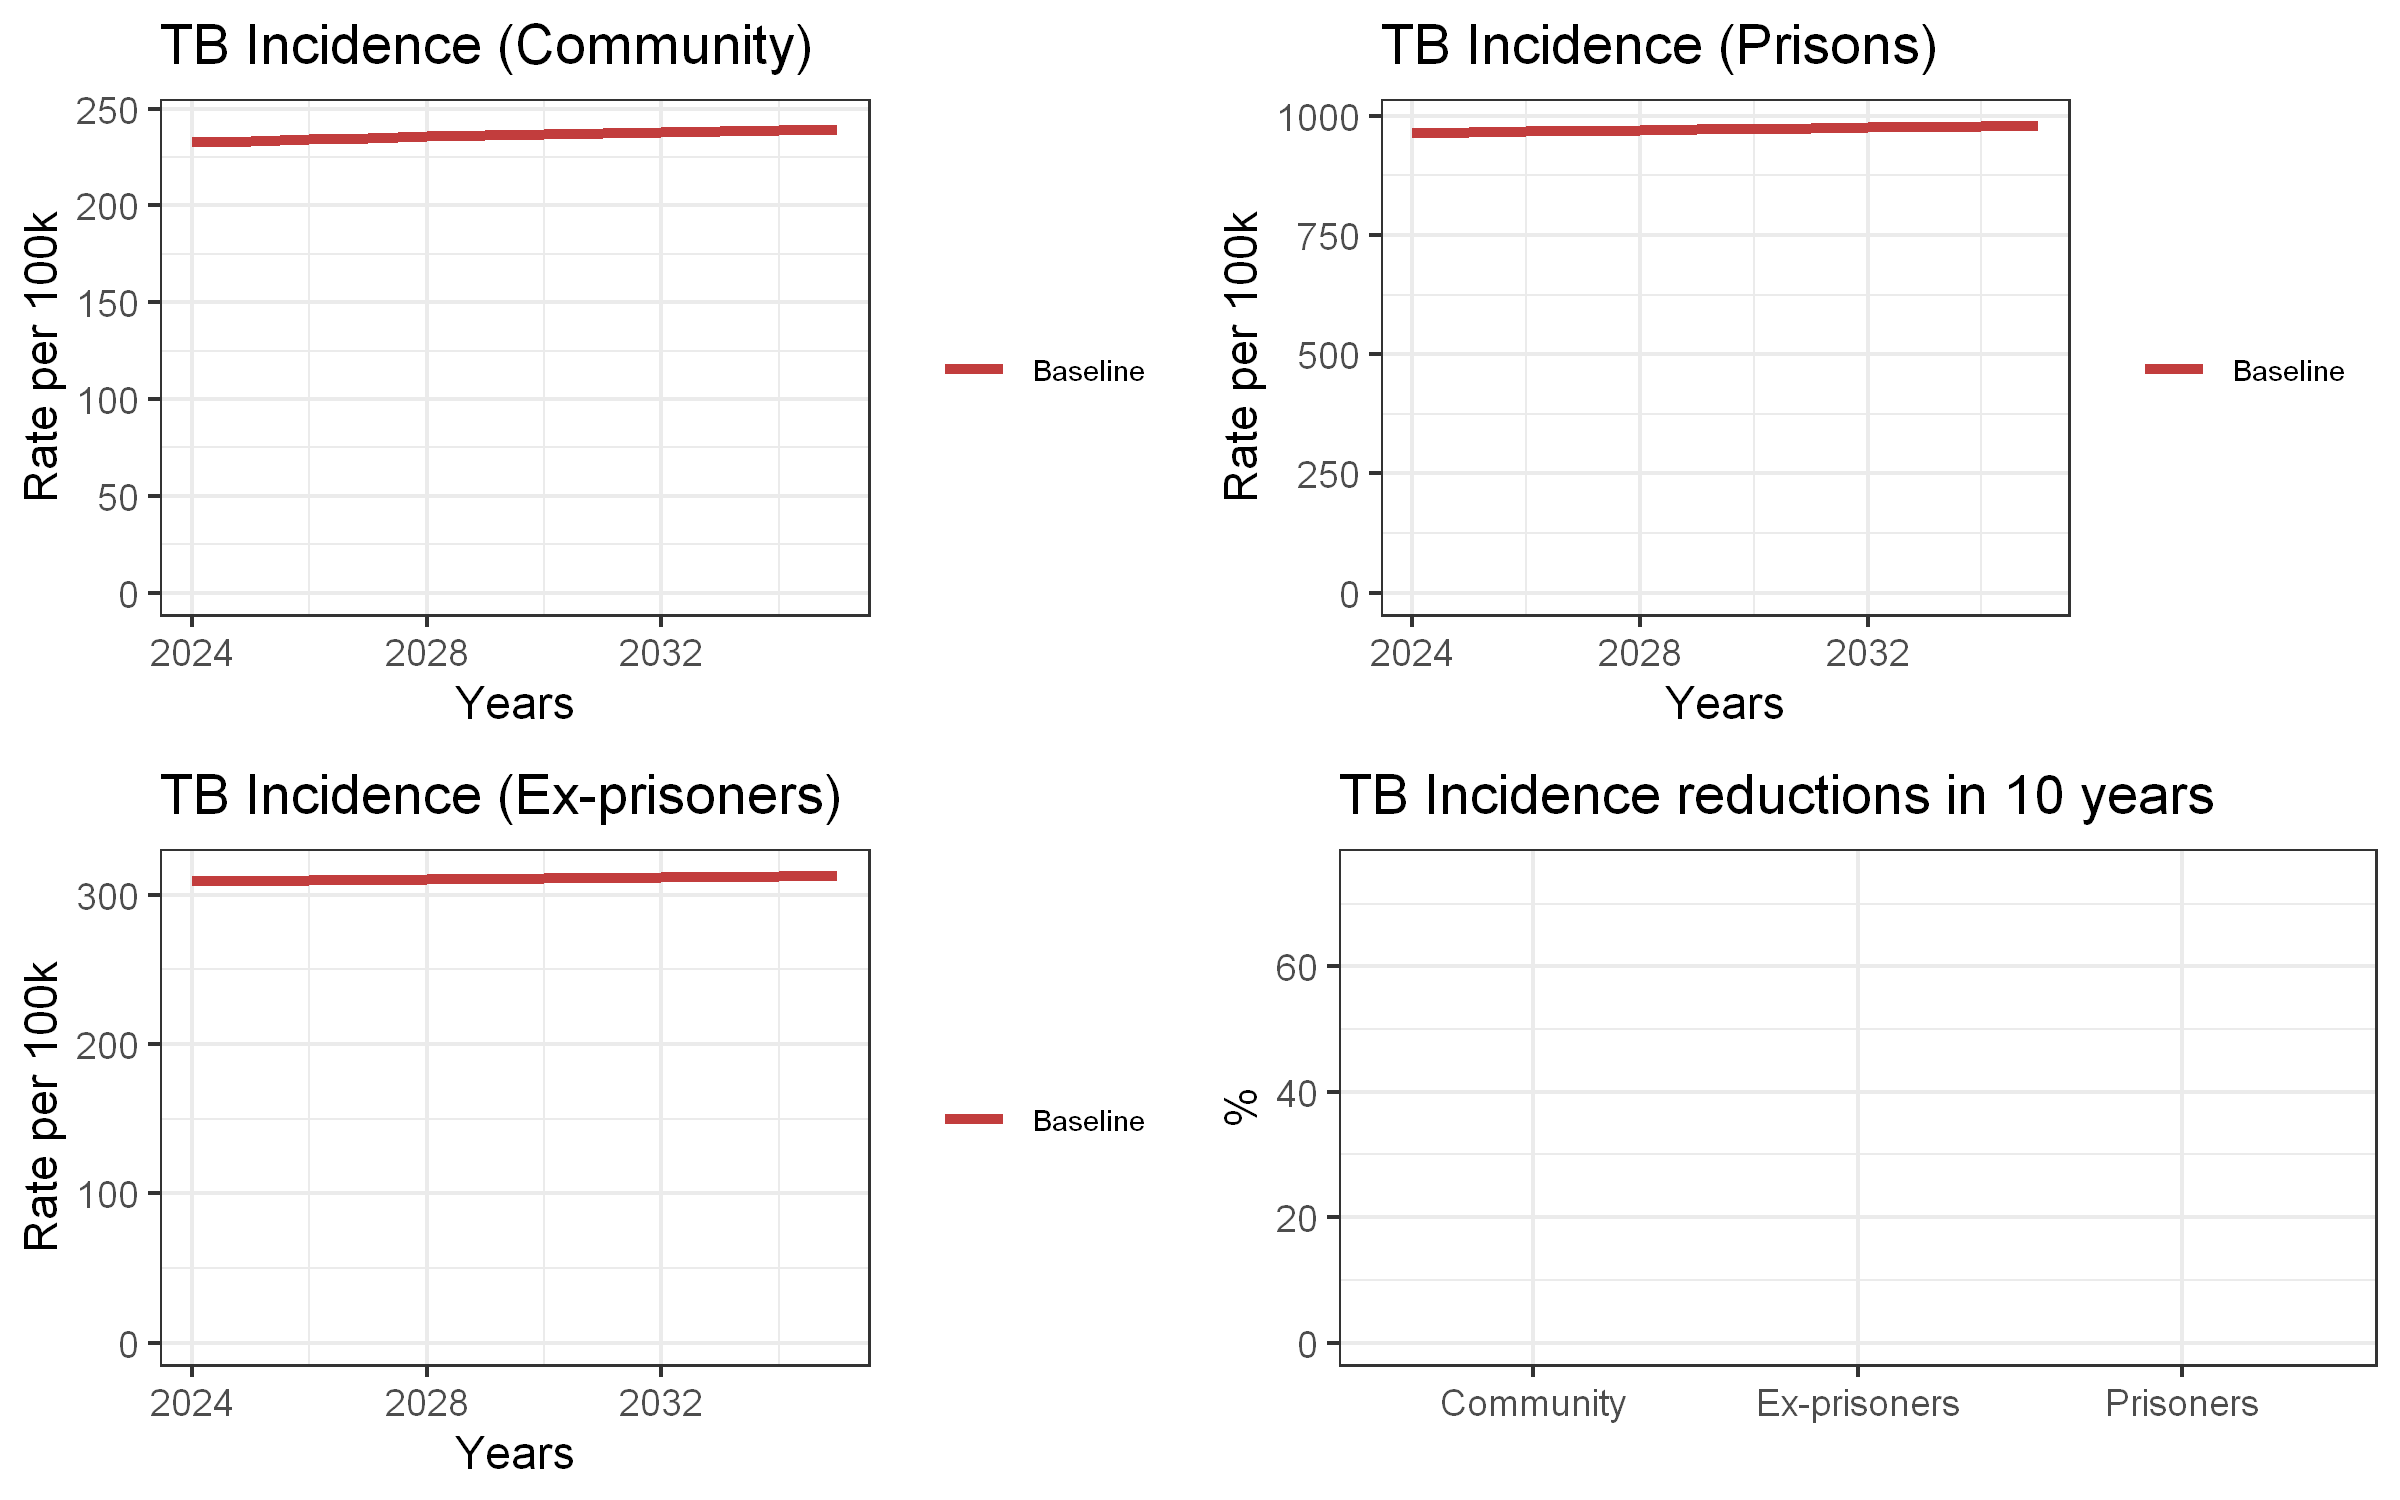

In [264]:
# simulation 0 ------------------------------------------------------------

# Project a baseline
int_name   <- "Baseline"

#Initial conditions (starting in 2024)
sfin       <- tail(out0$out,1)
times_new  <- seq(t.intervention, t.intervention+25 , by=1)
params_0<-params_base

data0<-get_intervention(sfin, 
                        params_0, 
                        NA,
                        times_new,
                        NA, 
                        int_name, 
                        NA) 


grid.arrange(data0$inc_c ,data0$inc_p,data0$inc_x,data0$reduc, nrow=2 )
inc_p_0<-data0$data$Incidence_p[1]

**Part II: Introduce interventions to tackle the high burden of TB in prisons**

You have been tasked to examine modelling scenarios in which TB burden in prisons can be reduced by 60% in the next 10 years. In the following code sections you will introduce a series of interventions sequentially, this is, you will see the cumulative effect of one intervention on top of the previous one. 

The first intervention you will introduce is improving TB diagnosis probability in prisons up to 95%. 

Run the code and explore the output figure. You will see incidence trajectories for the three populations and a bar chart with relative incidence reductions in the next 10 years. You can see that there is also a dashed line in the prisonners incdence plot. This indicates the target where you need want to bring incidence.  

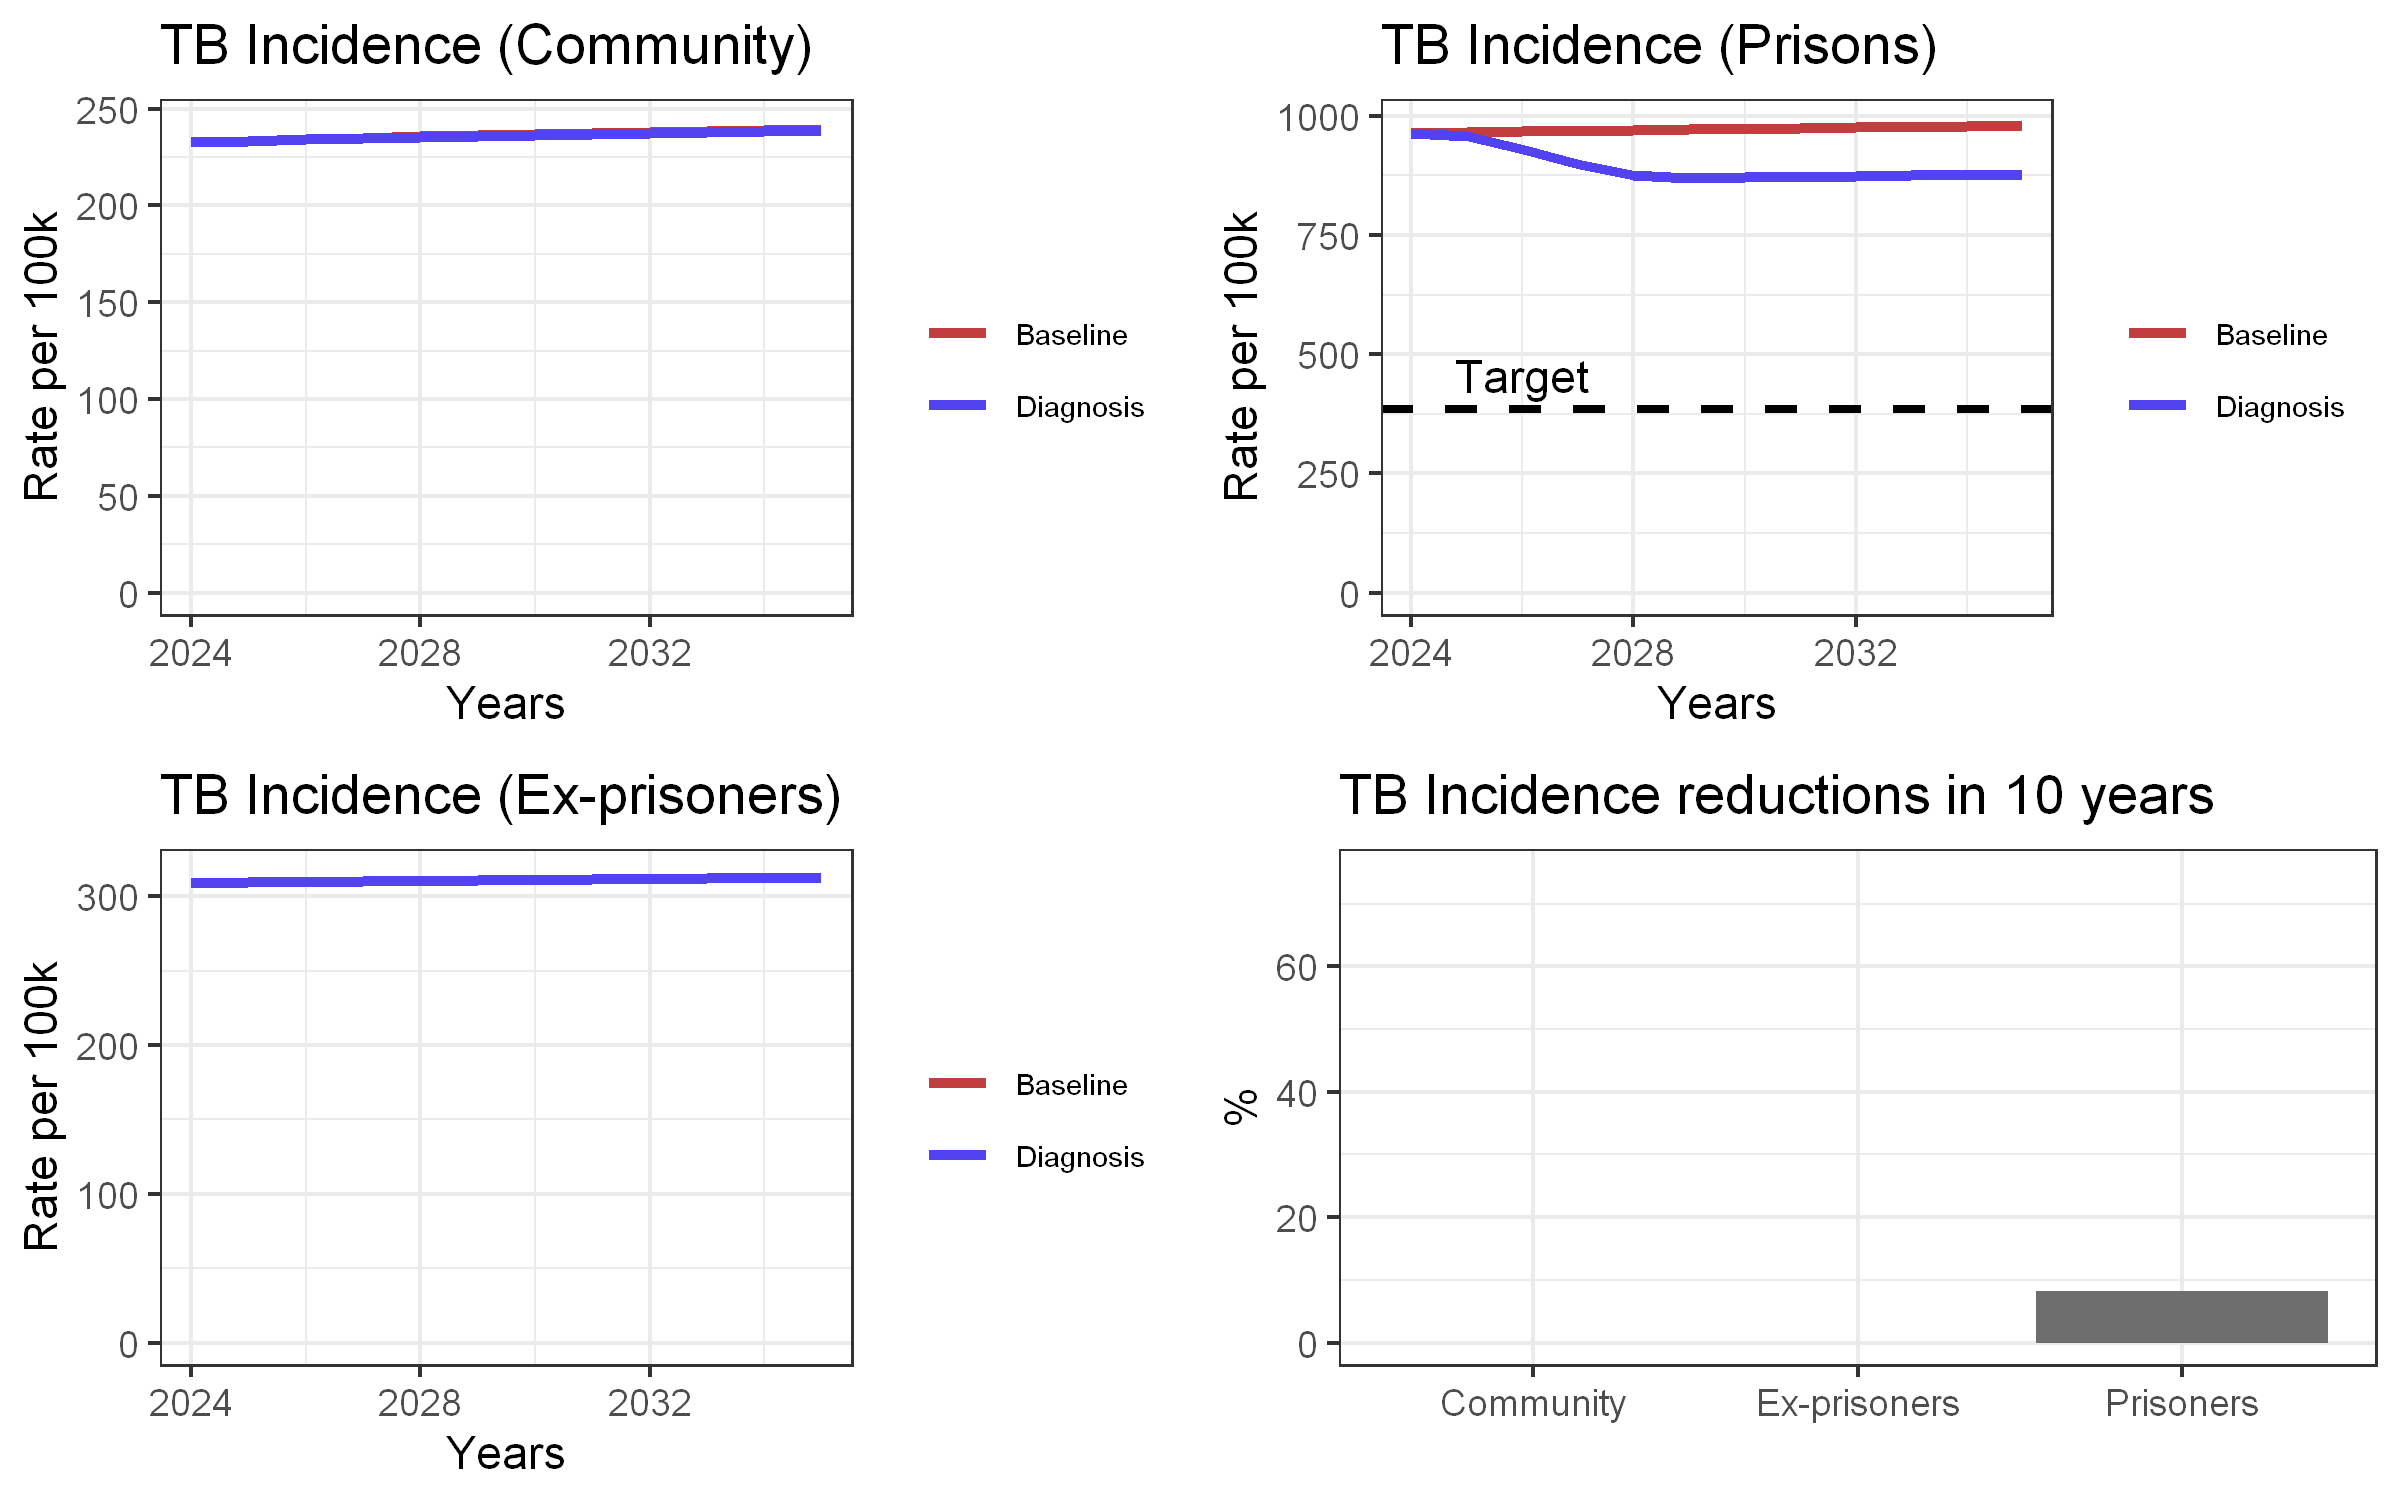

In [265]:
# Simulation 1 Diagnosis ----------------------------------------------------

# An Intervention simulating Diagnosis improvement in prisons
int_name   <- "Diagnosis"

#Update parameter results data frame to append new results
params_1 <-params_0
data_stub<-data0$data
t.interv   <- c(times_new[2], times_new[2]+t.scale)

# Change parameters for intervention
pDx_p  <- 0.95   # Probability of being diagnosed once sought care

cascade_p <-pDx_p*pTx_p*(1/(care_seeking_p+T.rTx))

params_1["selfcure_p"]<-selfcure_p + cascade_p

data1<-get_intervention(sfin, 
                        params_1, 
                        params_0,
                        times_new,
                        t.interv, 
                        int_name, 
                        data_stub) 

p1<-data1$inc_p +
  # Target
  geom_hline(yintercept=inc_p_0*(1-0.6), linetype="dashed", color = "black", linewidth=1)+
  annotate("text", x = 2026, y = inc_p_0*(1-0.6), label = "Target", vjust = -0.5)



grid.arrange(data1$inc_c ,p1,data1$inc_x,data1$reduc, nrow=2 )

The following intervention simulates an improvement in the probability of TB treatment (provided a previous diagnosis) of up to 95% in prisons. 

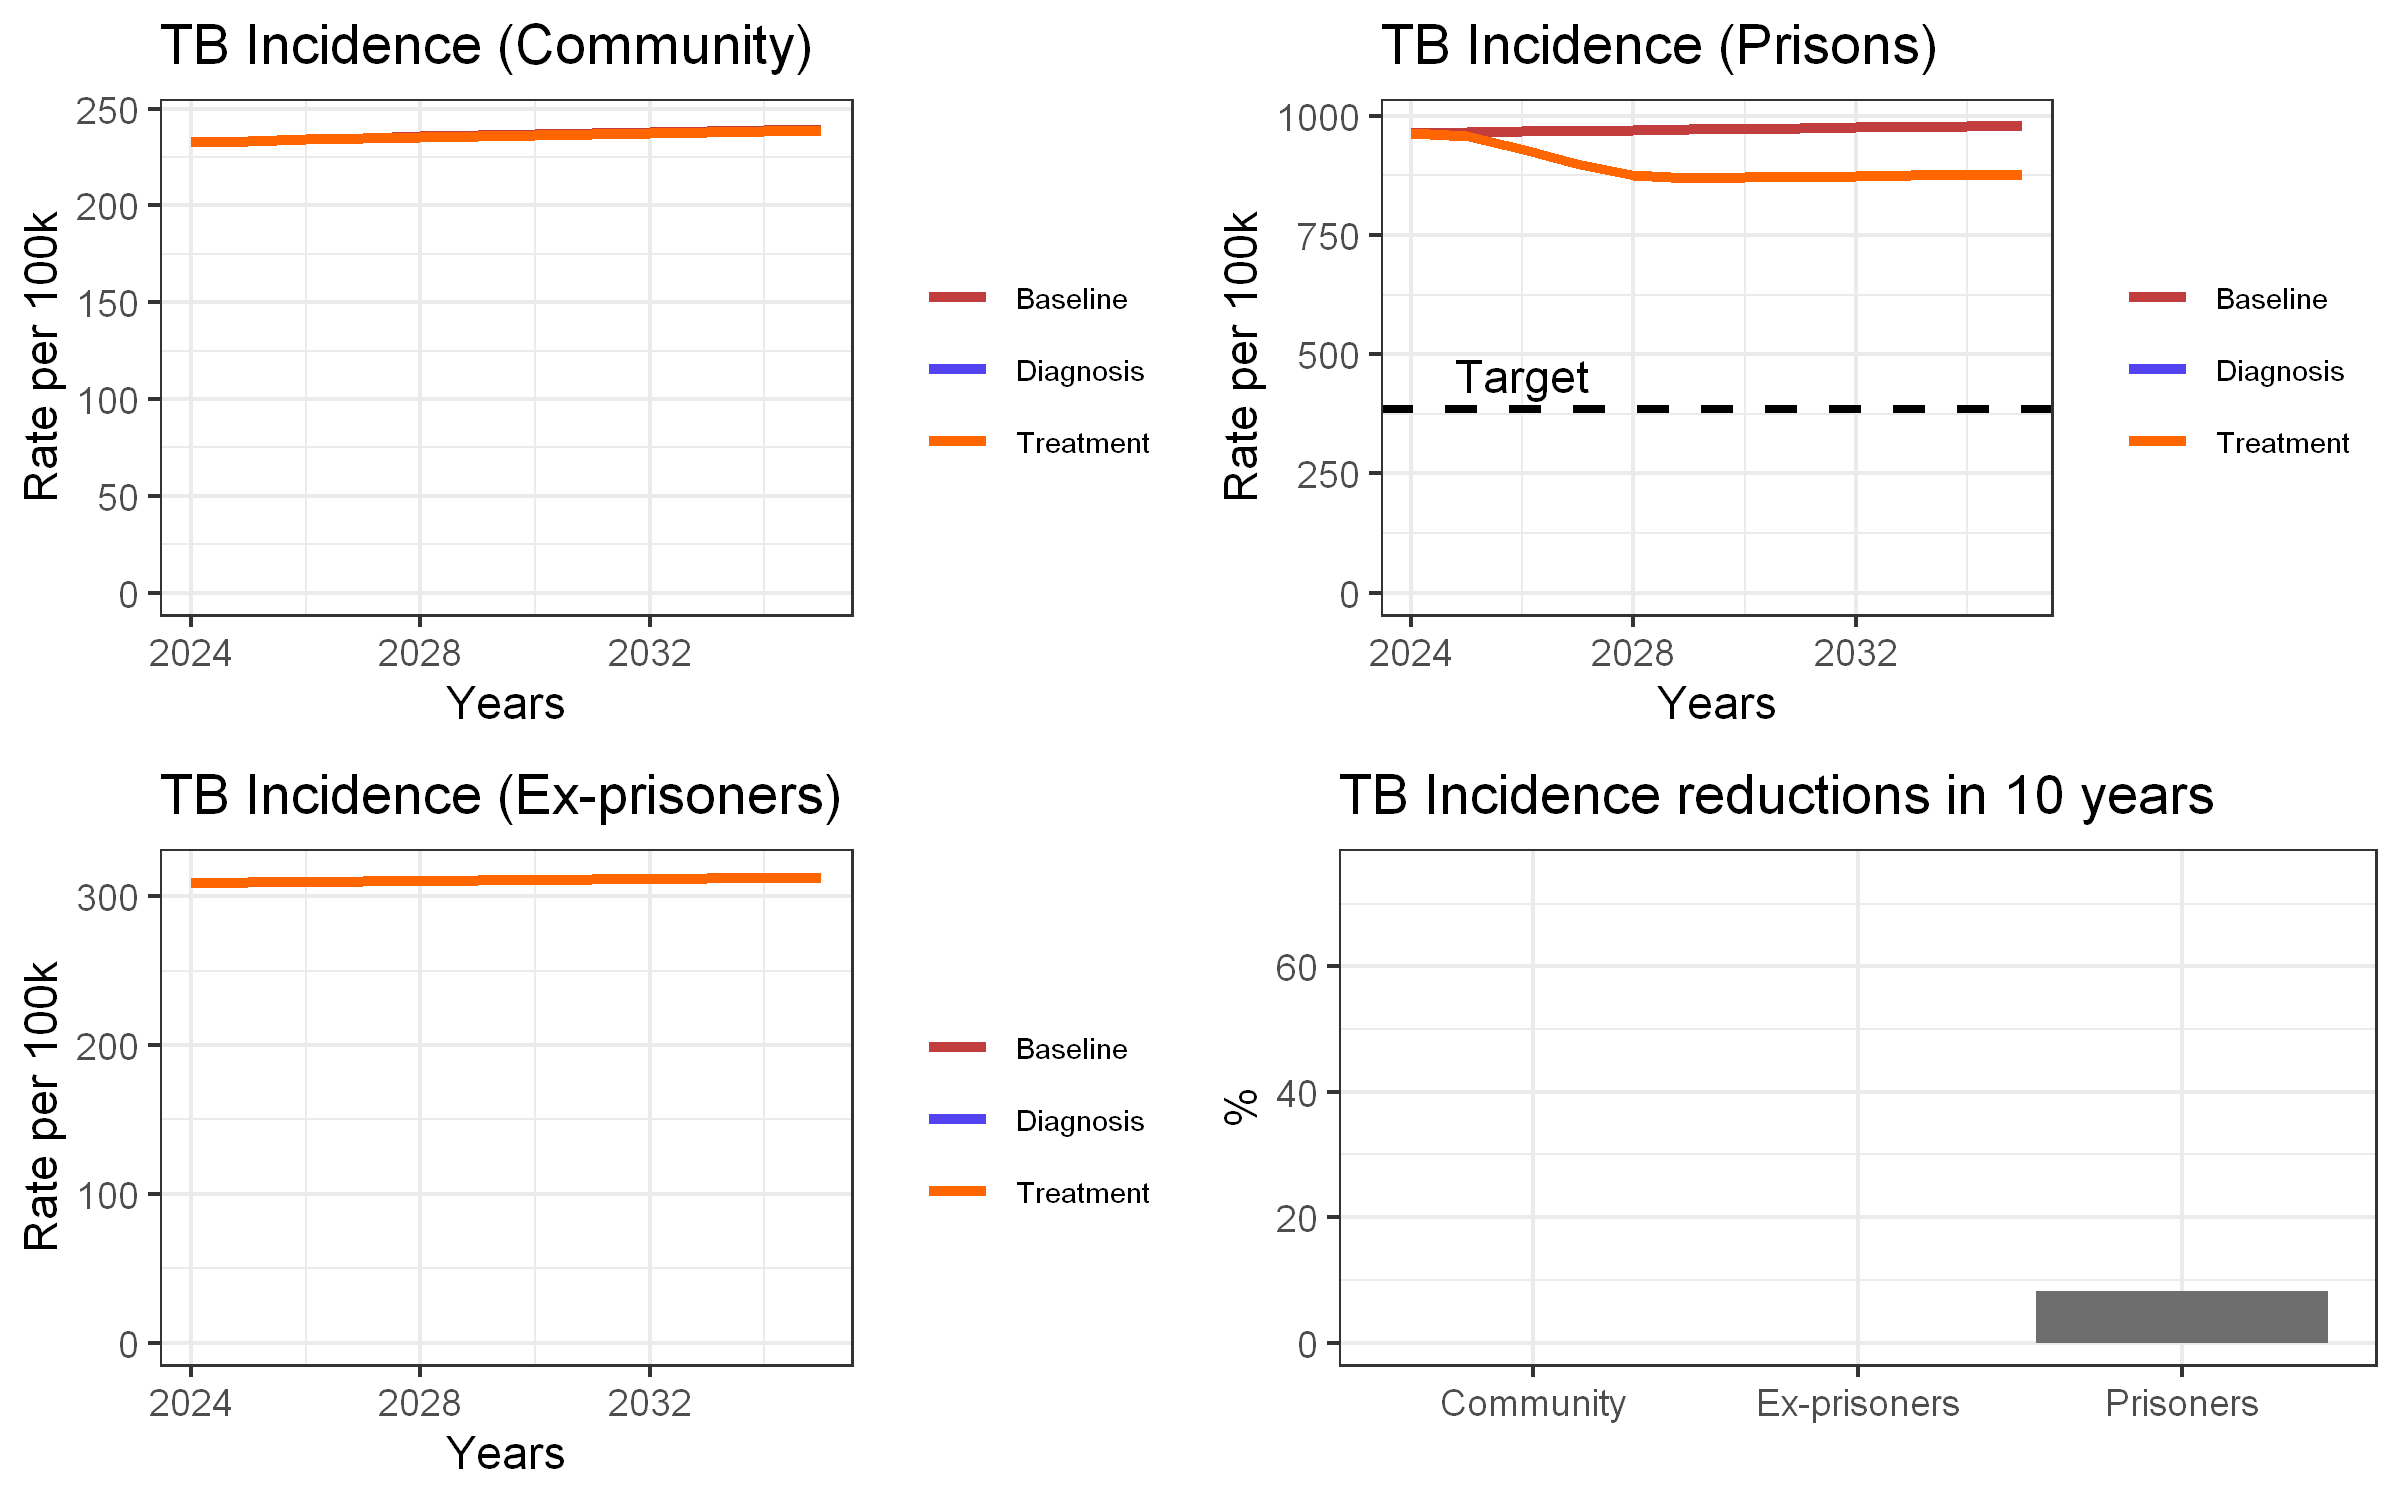

In [266]:
# Simulation 2 Treatment ----------------------------------------------------

# An Intervention simulating Treatment improvement in prisons
int_name   <- "Treatment"

#Update parameter results data frame to append new results
params_2 <-params_0
data_stub<-data1$data

# Change parameters for intervention
pDx_p  <- 0.95   # Probability of being diagnosed once sought care
pTx_p  <- 0.95   # Probability of being diagnosed once sought care

cascade_p <-pDx_p*pTx_p*(1/(care_seeking_p+T.rTx))

params_2["selfcure_p"]<-selfcure_p + cascade_p

data2<-get_intervention(sfin, 
                        params_2, 
                        params_0,
                        times_new,
                        t.interv, 
                        int_name, 
                        data_stub) 

p1<-data2$inc_p +
  # Target
  geom_hline(yintercept=inc_p_0*(1-0.6), linetype="dashed", color = "black", linewidth=1)+
  annotate("text", x = 2026, y = inc_p_0*(1-0.6), label = "Target", vjust = -0.5)



grid.arrange(data2$inc_c ,p1,data2$inc_x,data2$reduc, nrow=2 )

Next we want to see the impact of reducing the time delay between developing symptoms and accessing diagnstic and treatment services. This is currently 1 year, and we would like to reduce it to 6 months (i.e, 50%). In practical terms this would be achieved by reducing barries for accessing services, and increasing the demand for TB services (e.g, awareness campaigns, increase access points)   

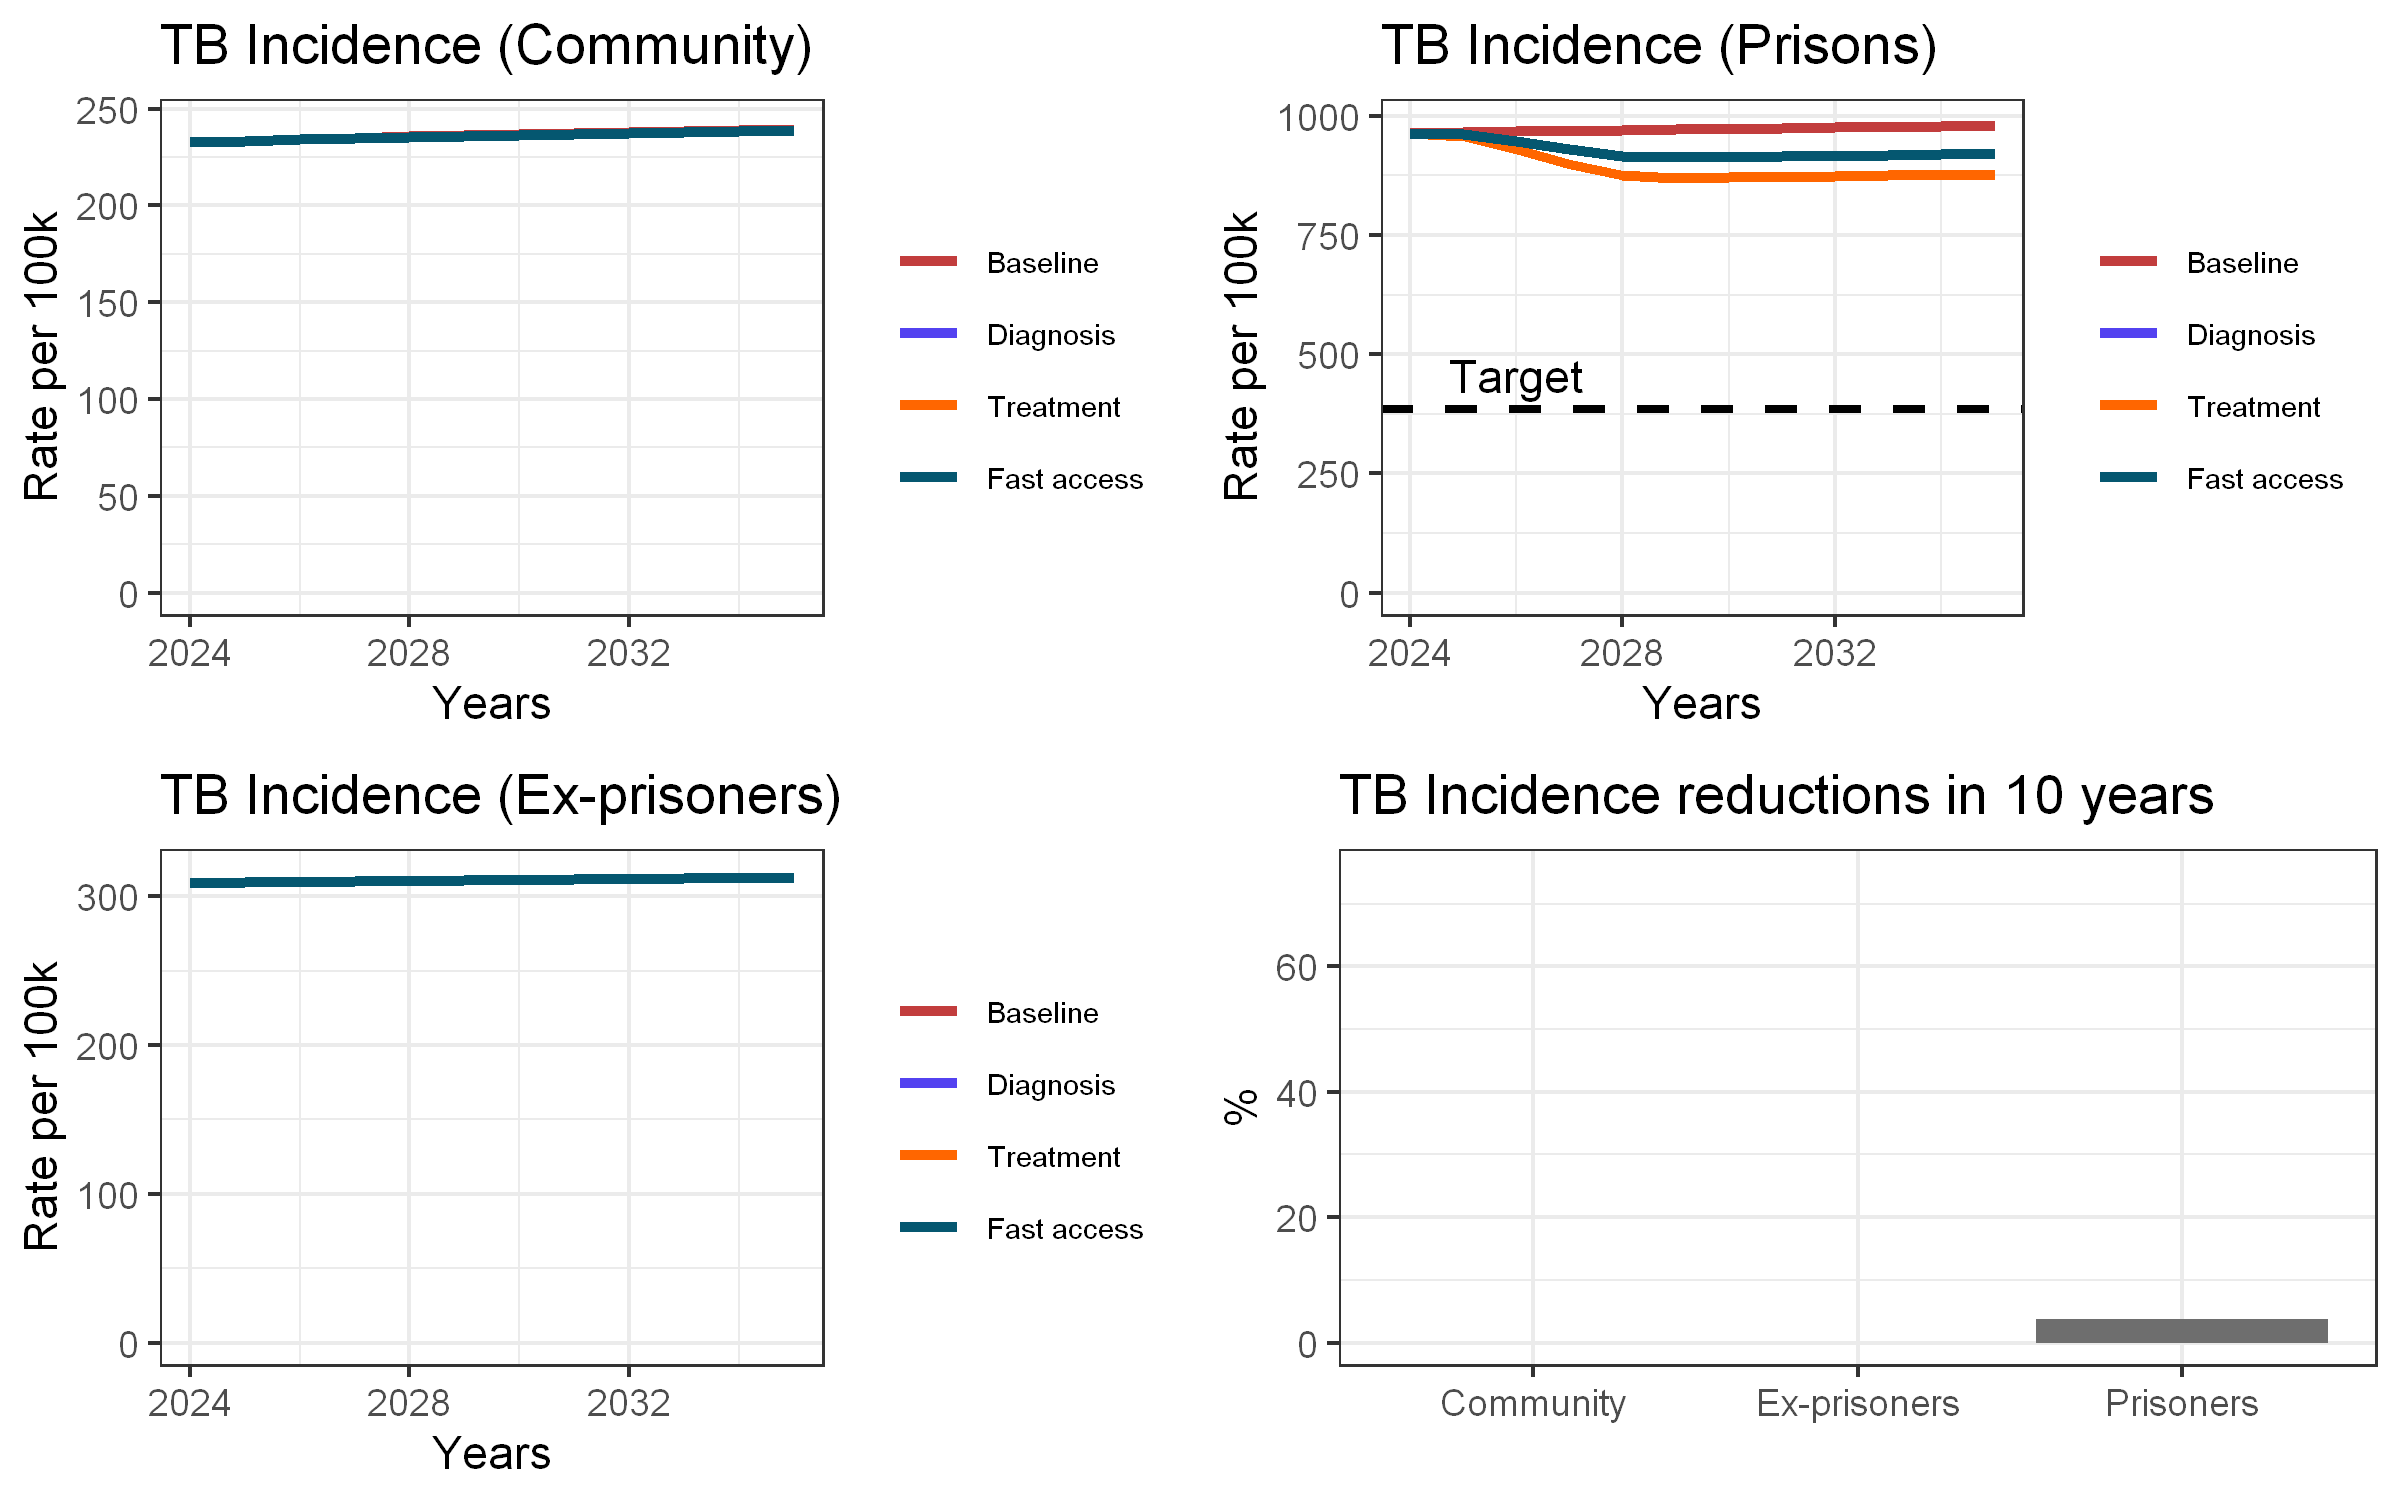

In [267]:
# Simulation 3 improve careseeking ----------------------------------------

int_name   <- "Fast access"

#Update parameter results data frame to append new results
params_3 <-params_2
data_stub<-data2$data

# Change parameters for intervention
care_seeking_p <-  1*(1-0.5)    # Time delay (yrs) between developing symptoms and seeking for care
pDx_p  <-  0.95     # Probability of being diagnosed once sought care
pTx_p  <-  0.95     # probability of receiving correct Tx if diagnosed

cascade_p <-pDx_p*pTx_p*(1/(care_seeking_p+T.rTx))

params_3["selfcure_p"]<-selfcure_p + cascade_p

data3<-get_intervention(sfin,
                        params_3, 
                        params_0,
                        times_new,
                        t.interv, 
                        int_name, 
                        data_stub) 

p1<-data3$inc_p +
  # Target
  geom_hline(yintercept=inc_p_0*(1-0.6), linetype="dashed", color = "black", linewidth=1)+
  annotate("text", x = 2026, y = inc_p_0*(1-0.6), label = "Target", vjust = -0.5)


grid.arrange(data3$inc_c ,p1,data3$inc_x,data3$reduc, nrow=2 )


Now that the full cascade of care has been intervened (seek care to treatment) , we look upstream to TB prevention strategies. The next chunk of code introduces an interventions that aims at detecting 90% of the LTBI + imprisoned population, treat 90% of those positive with a 3-month TPT regimen (i.e, 3HP) for an assumed regimen of efficay of 70%. 

*Note: see how we introduce this intervention by modifying the 'break-in rate of reactivation*

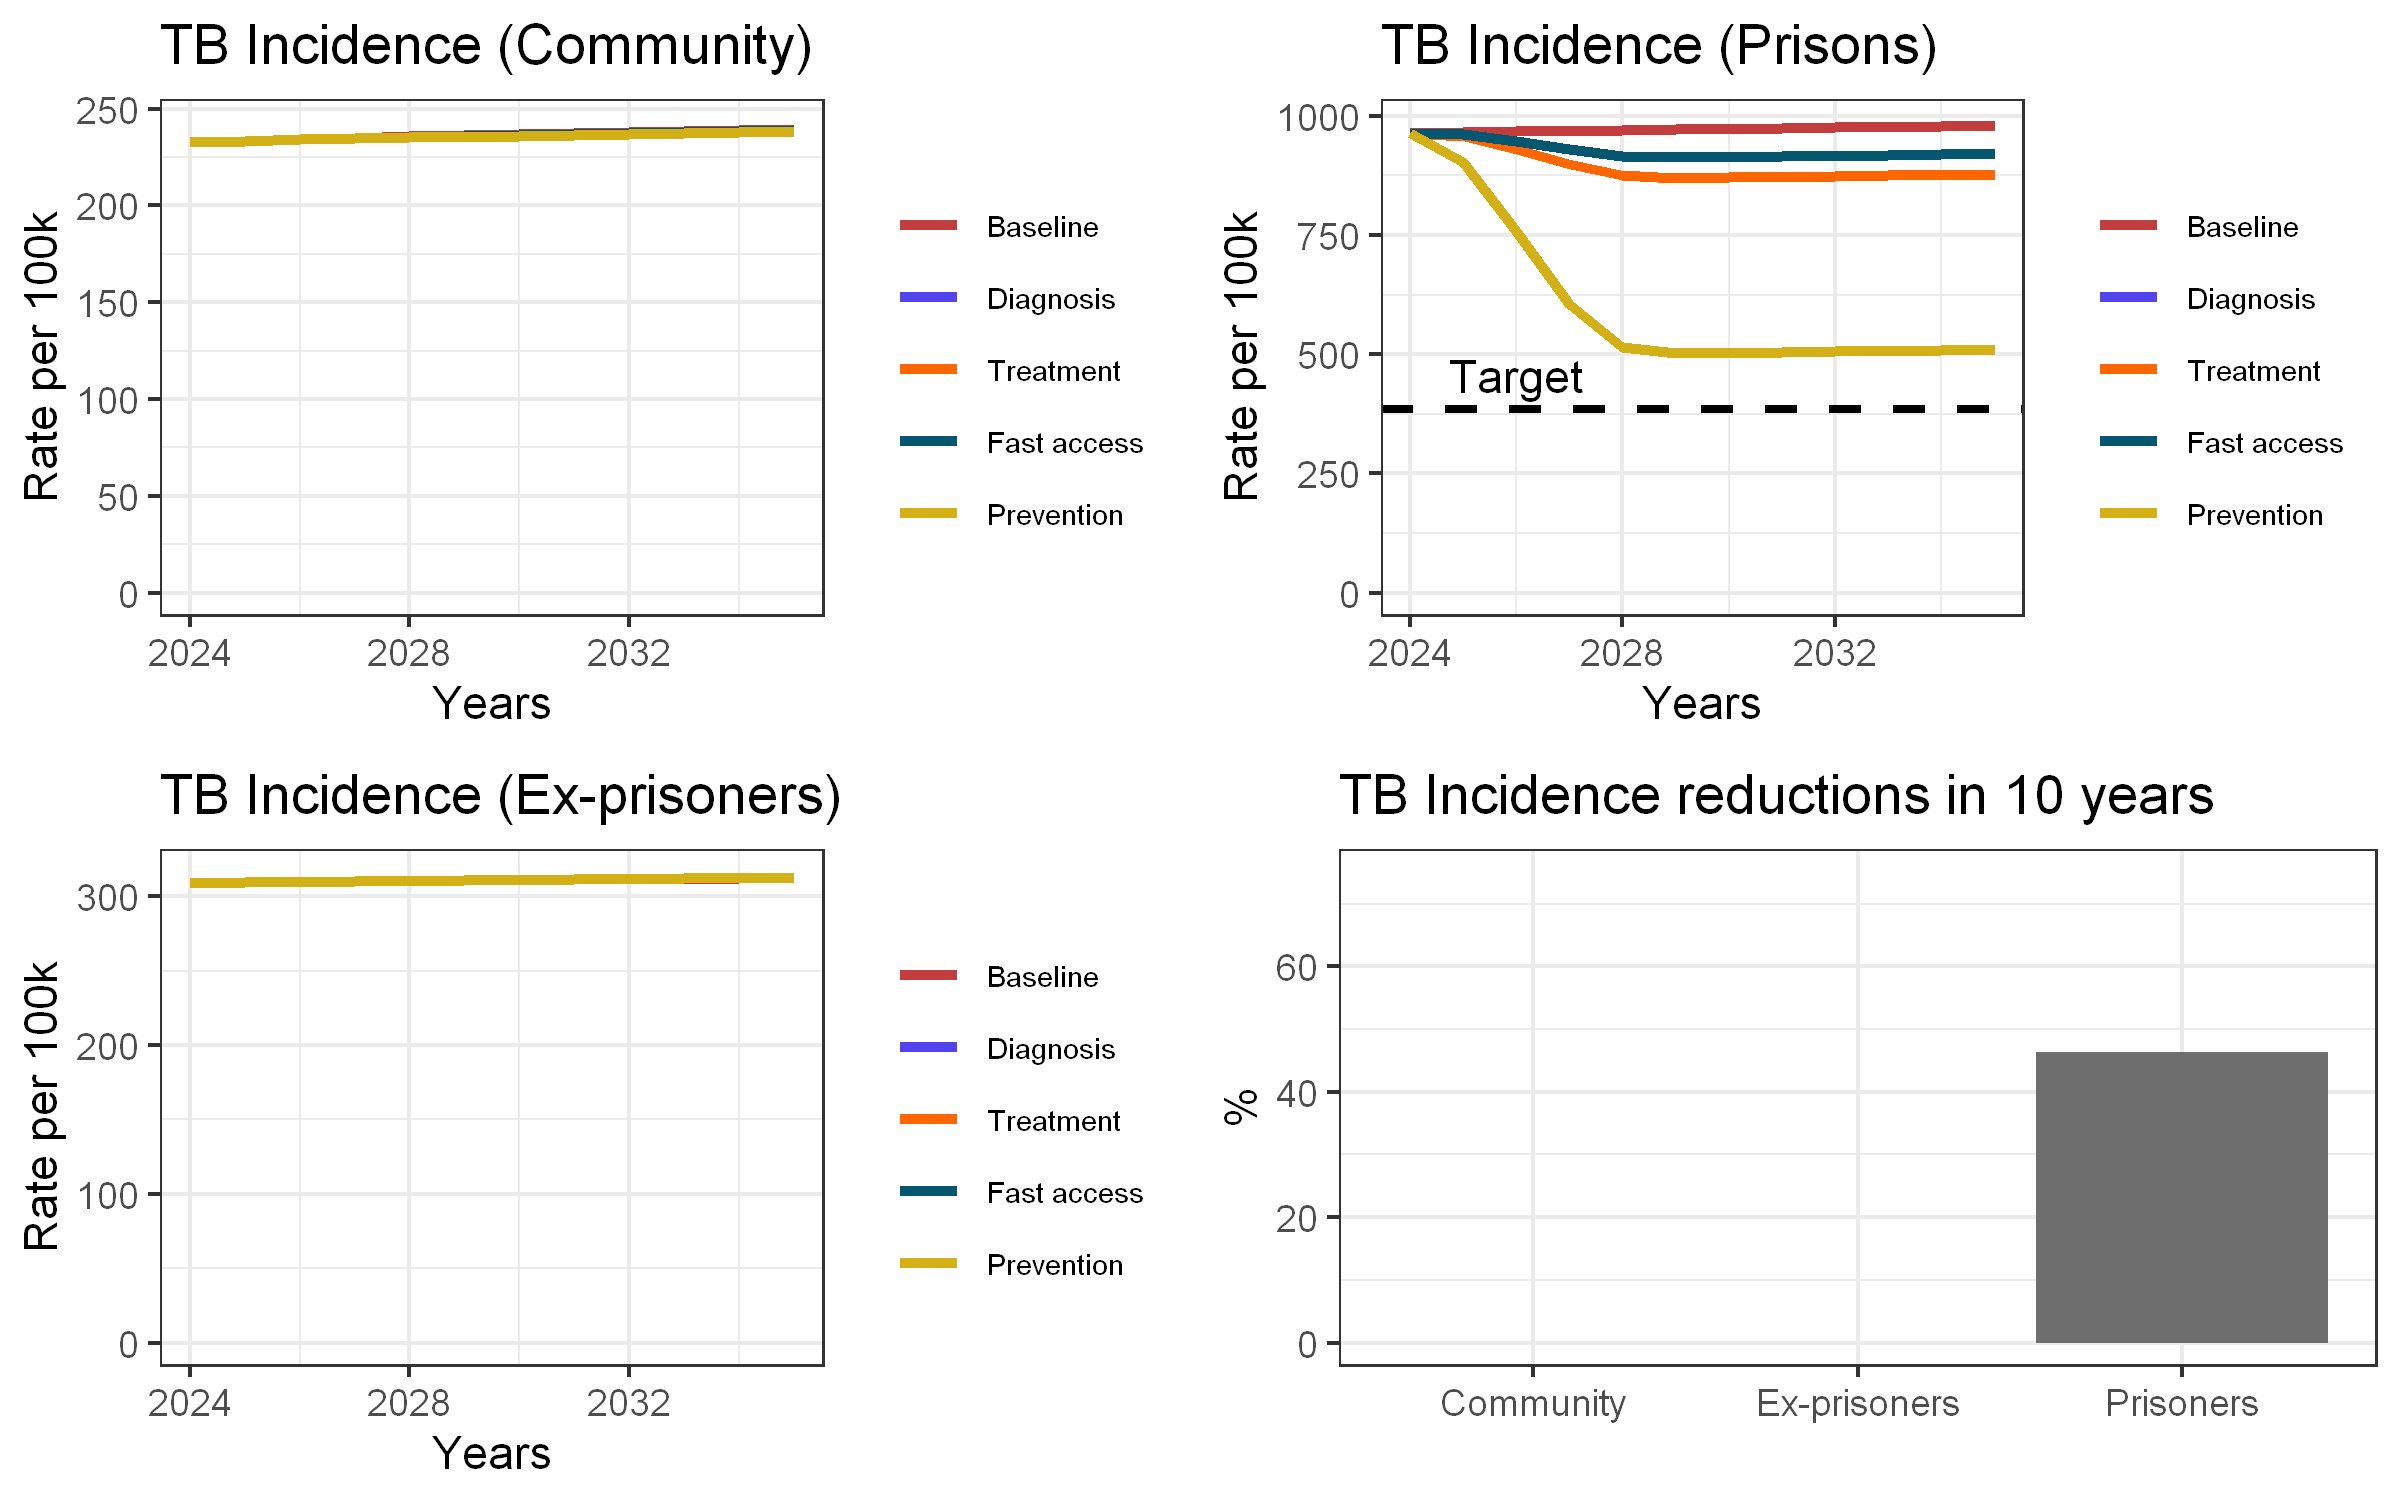

In [268]:
# Simulation 4 Prevention -------------------------------------------------

# An Intervention simulating LTBI treatment
int_name<- "Prevention"

#Update parameter results data frame to append new results
params_4 <-params_3
data_stub<-data3$data


# Change parameters for intervention
care_seeking_p <-  1*(1-0.75)    # Time delay (yrs) between developing symptoms and seeking for care
pDx_p  <-  0.95     # Probability of being diagnosed once sought care
pTx_p  <-  0.95     # probability of receiving correct Tx if diagnosed

cascade_p <-pDx_p*pTx_p*(1/(care_seeking_p+T.rTx))

params_4["selfcure_p"]<-selfcure_p + cascade_p
params_4["break_in_p"]<- break_in_p*(1-0.7*0.9*0.9)

data4<-get_intervention(sfin, 
                        params_4, 
                        params_0,
                        times_new,
                        t.interv,
                        int_name, 
                        data_stub) 


p1<-data4$inc_p +
  # Target
  geom_hline(yintercept=inc_p_0*(1-0.6), linetype="dashed", color = "black", linewidth=1)+
  annotate("text", x = 2026, y = inc_p_0*(1-0.6), label = "Target", vjust = -0.5)


grid.arrange(data4$inc_c ,p1,data4$inc_x,data4$reduc, nrow=2 )

As you can see, with the introduced interventions in prisons it is not yet feasible to achieve the set target of 60% incidence reduction in prisons. We move now to target the ex-imprisoned population to see if we can strengthen the effect of our intervention package.

We will first reduce the time from TB symptoms to accessing care in this population

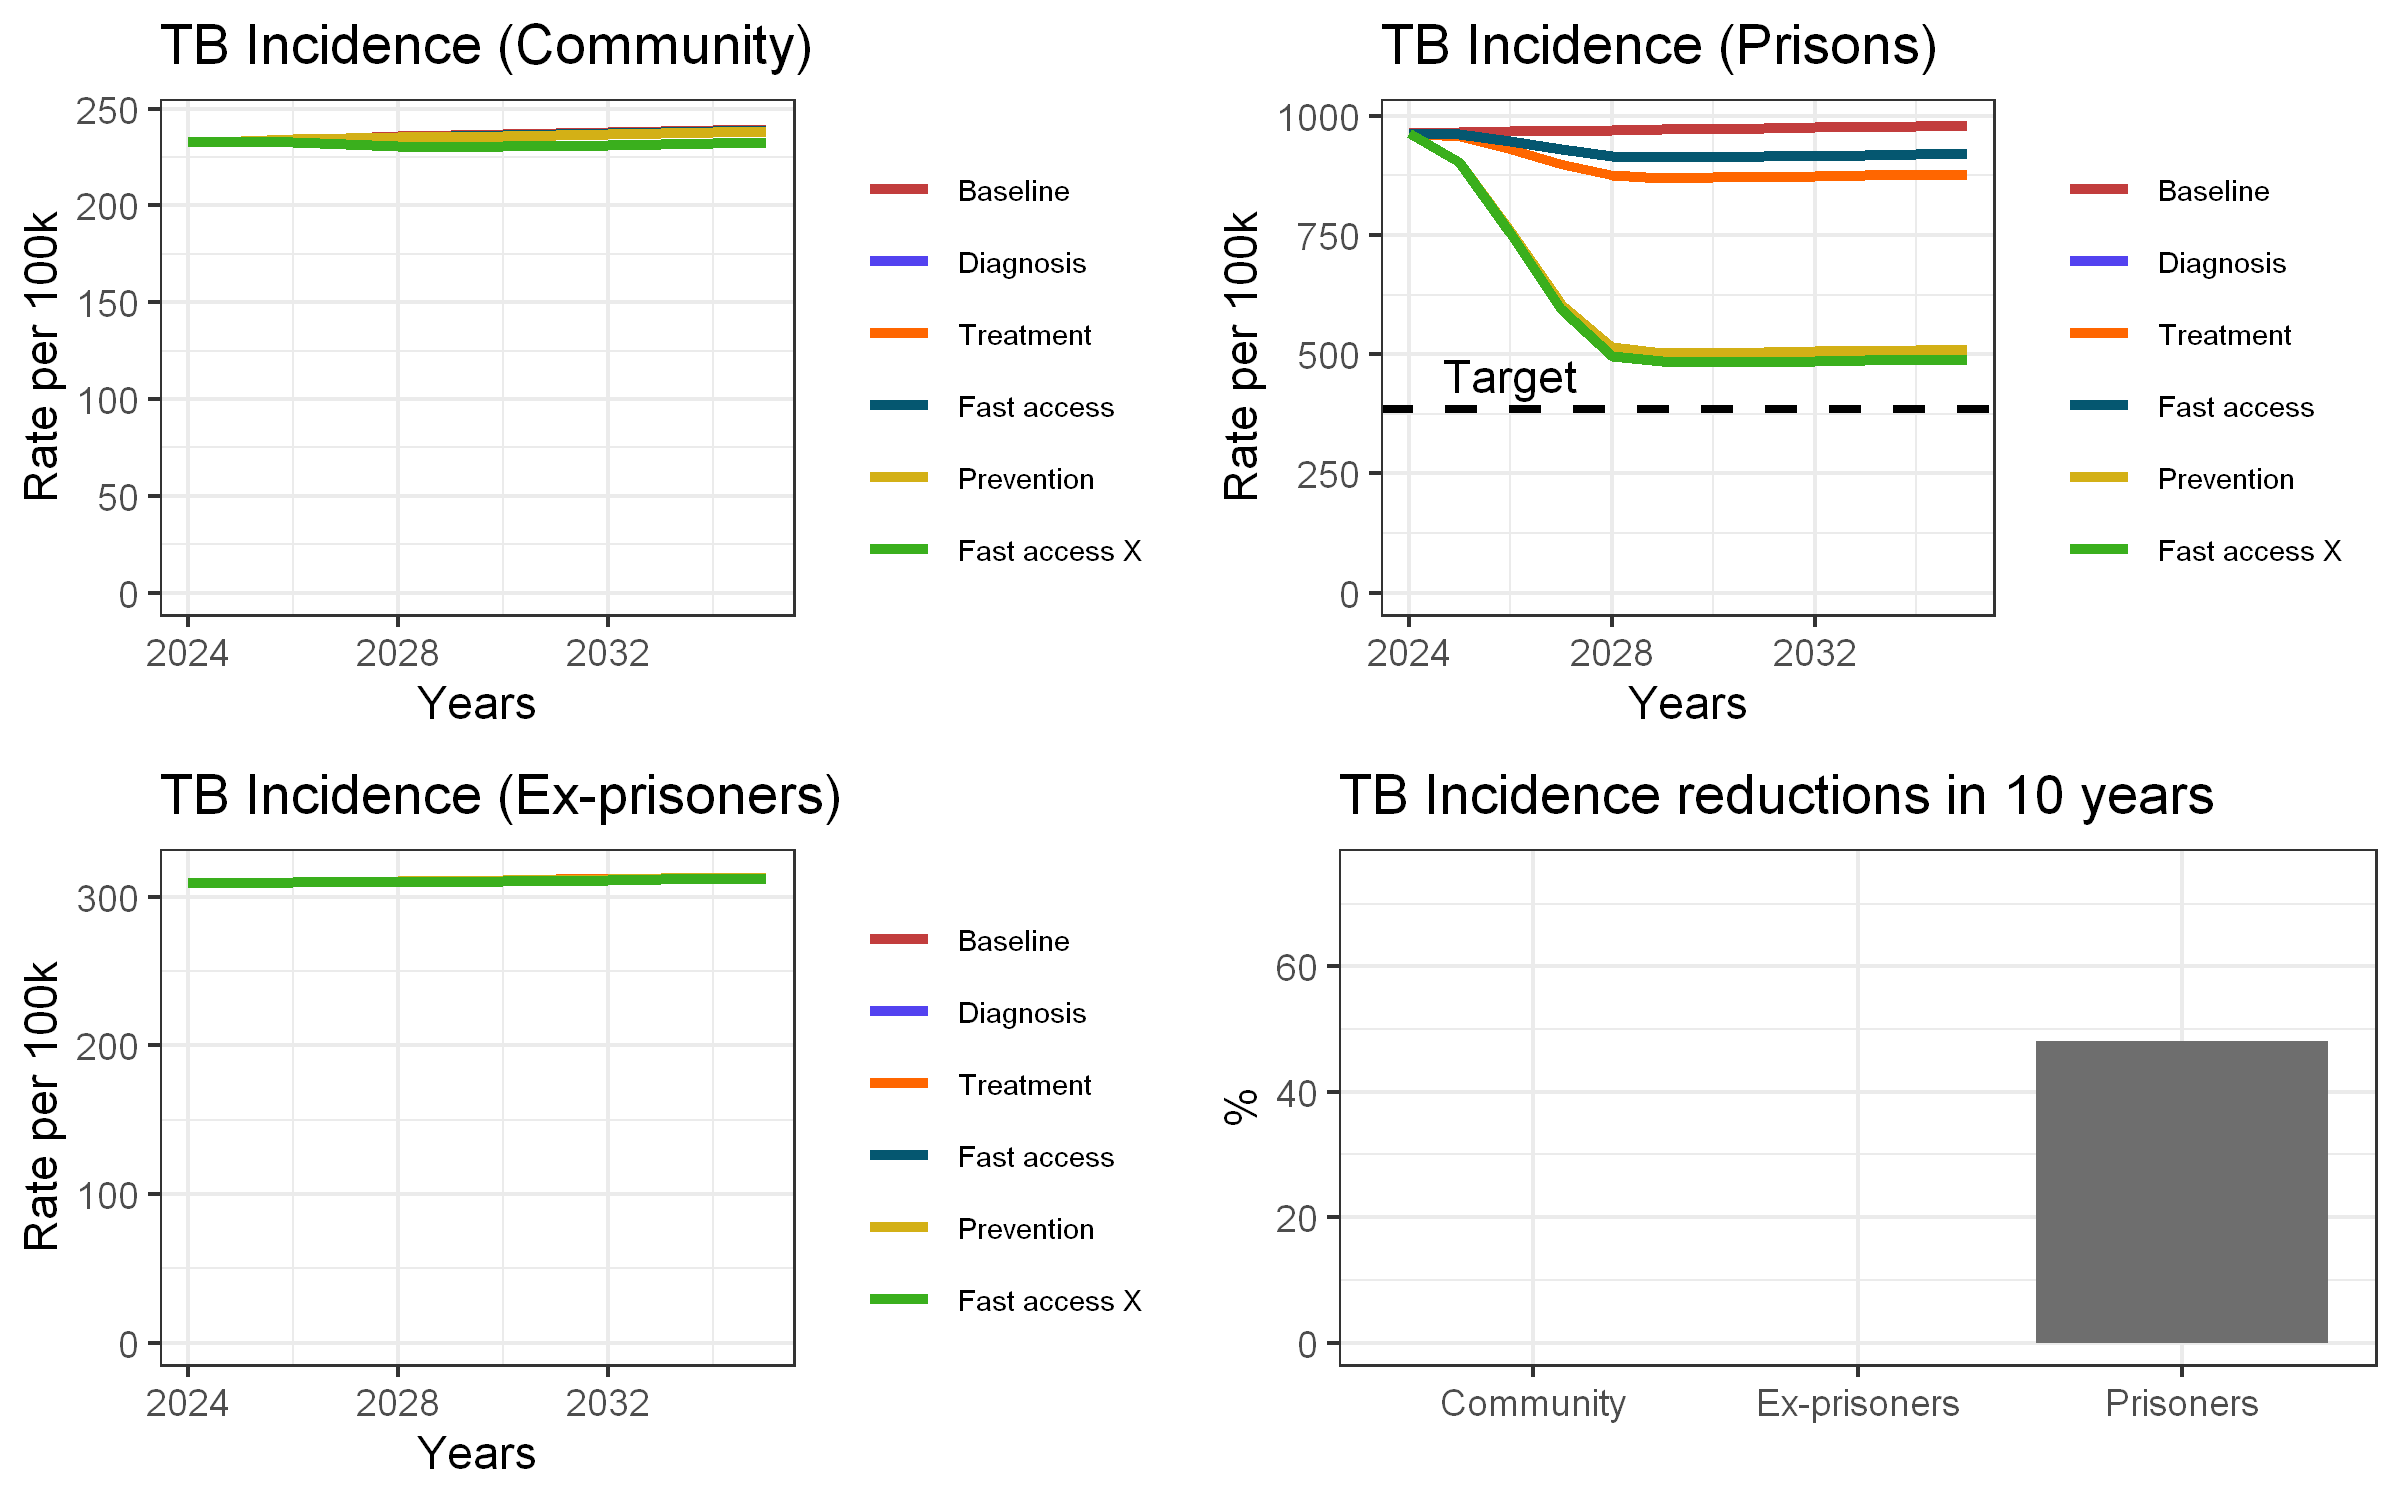

In [269]:
# Simulation 5 improve careseeking ----------------------------------------

int_name   <- "Fast access X"

#Update parameter results data frame to append new results
params_5 <-params_4
data_stub<-data4$data

# Change parameters for intervention
care_seeking_x <-  1*(1-0.5)    # Time delay (yrs) between developing symptoms and seeking for care

cascade_x <-pDx_x*pTx_x*(1/(care_seeking_x+T.rTx))

params_5["selfcure_x"]<-selfcure_x + cascade_x

data5<-get_intervention(sfin,
                        params_5, 
                        params_0,
                        times_new,
                        t.interv, 
                        int_name, 
                        data_stub) 

p1<-data5$inc_p +
  # Target
  geom_hline(yintercept=inc_p_0*(1-0.6), linetype="dashed", color = "black", linewidth=1)+
  annotate("text", x = 2026, y = inc_p_0*(1-0.6), label = "Target", vjust = -0.5)


grid.arrange(data5$inc_c ,p1,data5$inc_x,data5$reduc, nrow=2 )

Finally, we want to introduce a TB prevention strategy among ex-prisoners. This strategy will aim at targeting newly released prisoners, offer LTBI teesting and treat with 3HP at least 90% of those resulting IGRA positive 

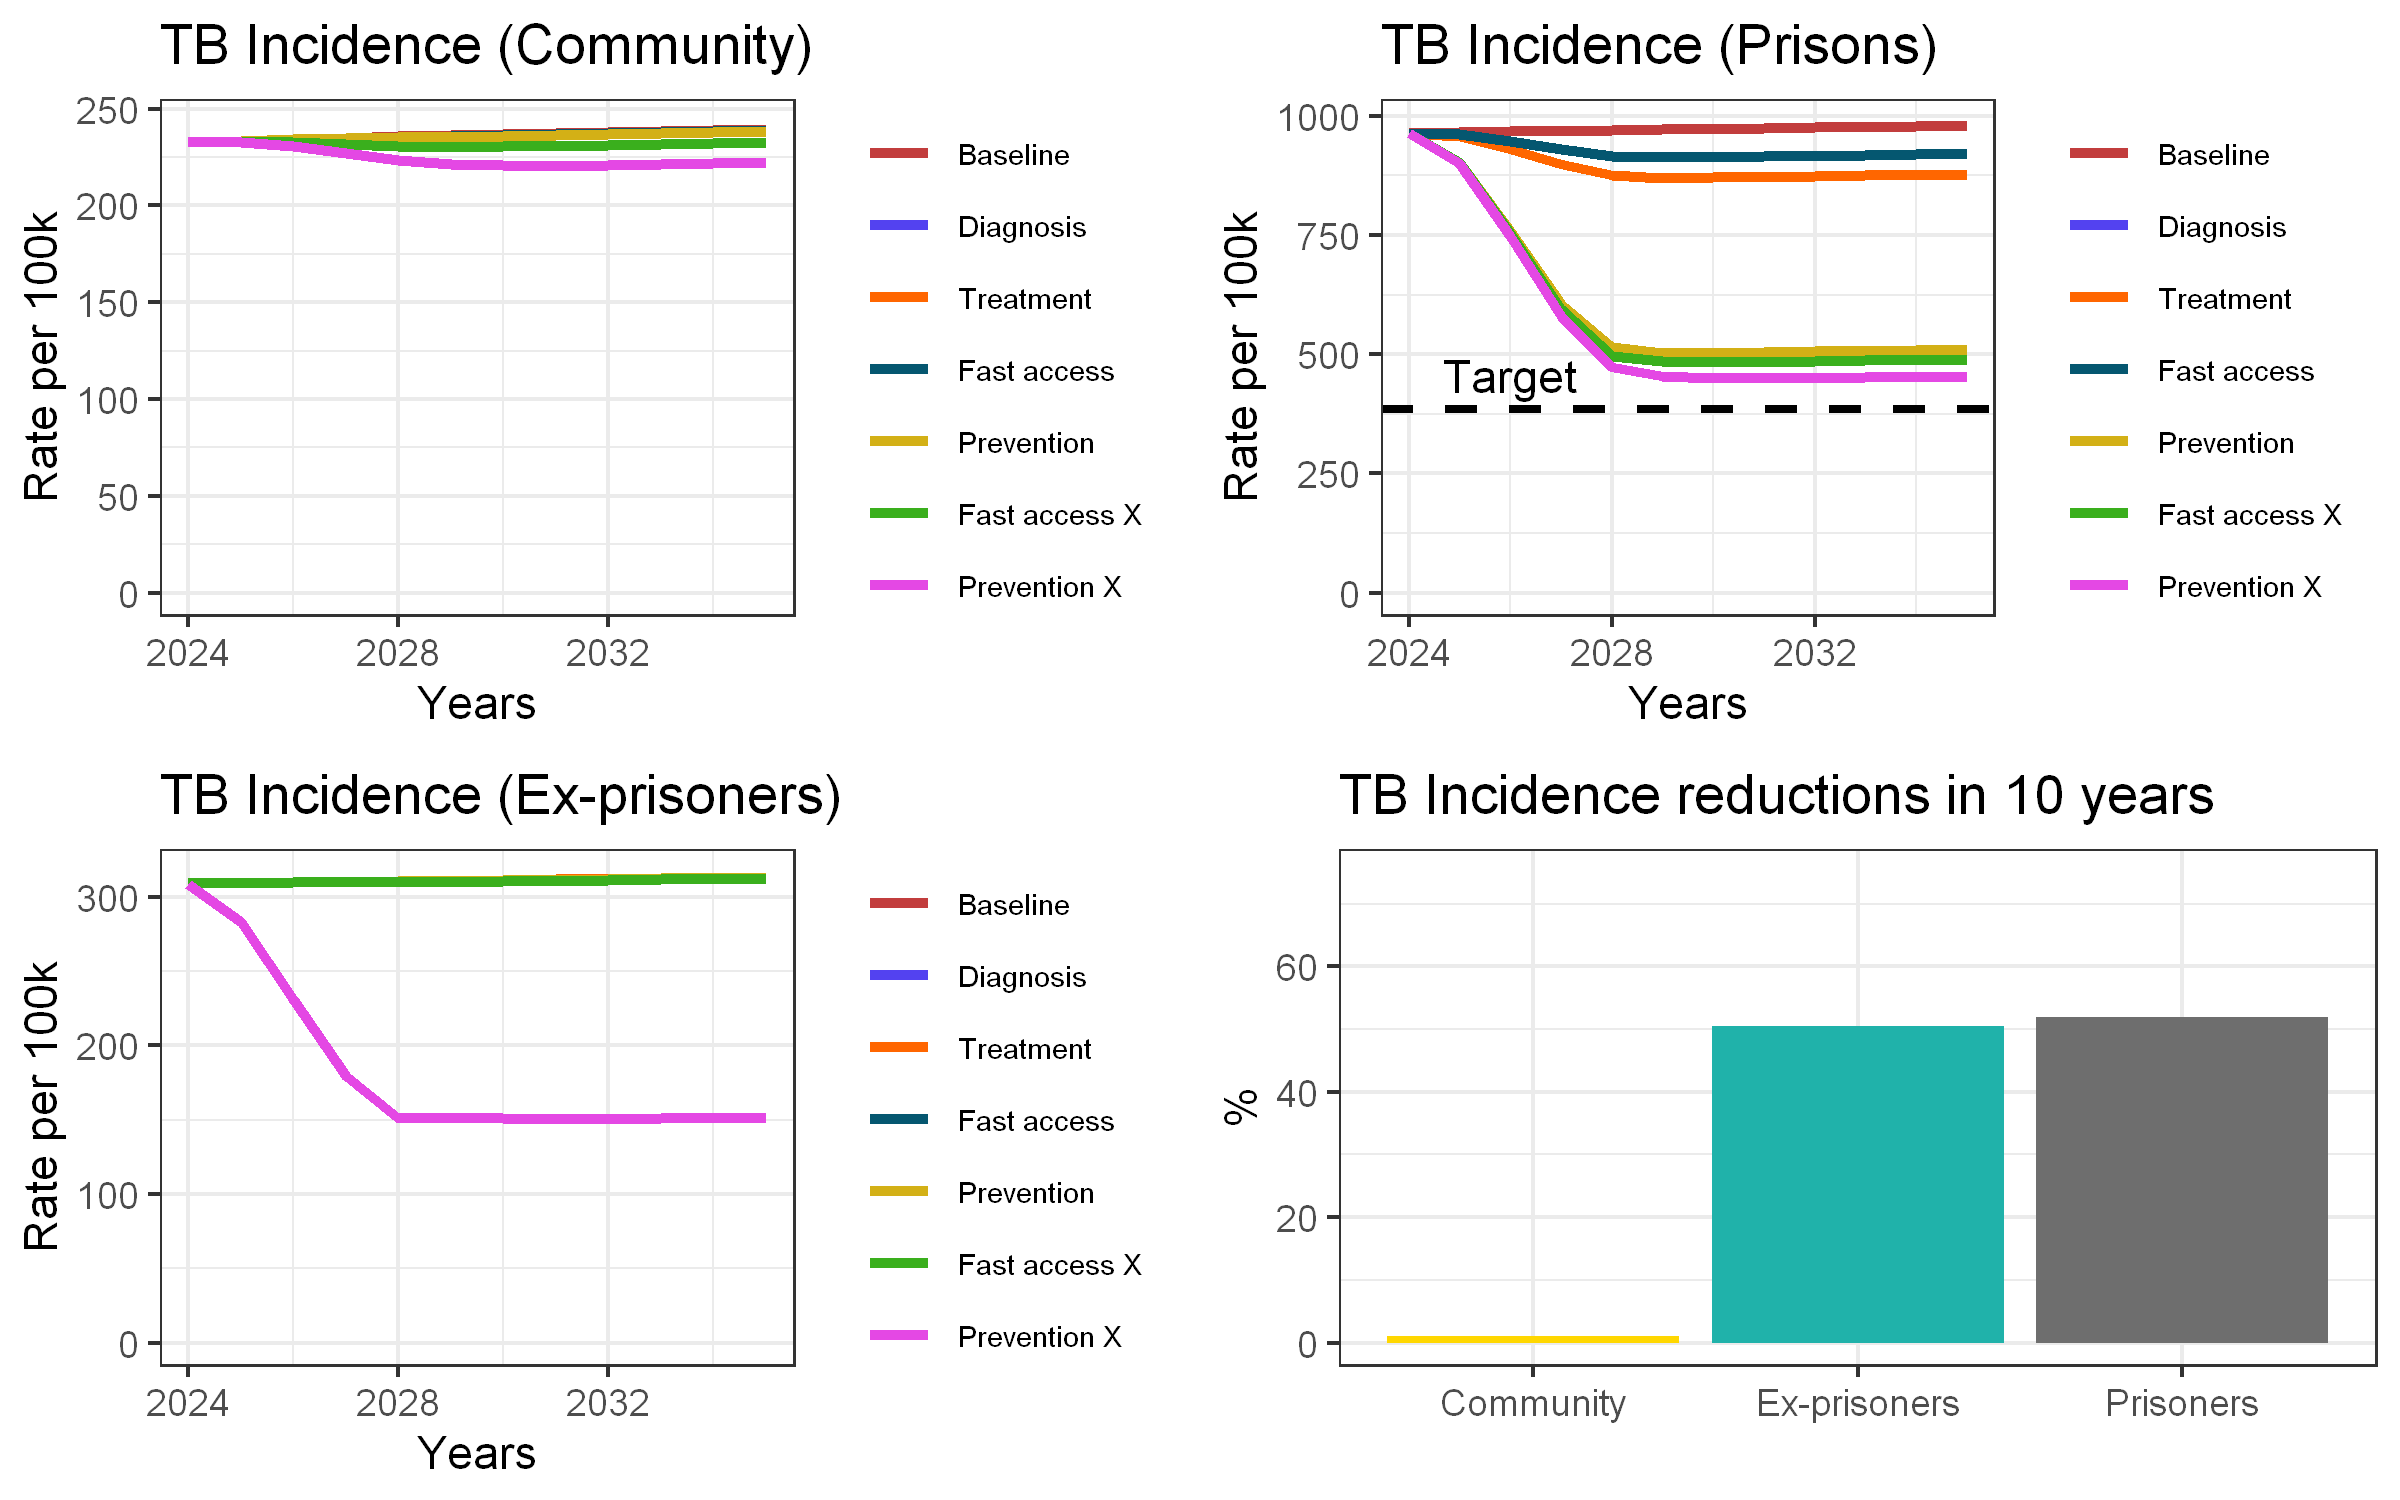

In [270]:
# Simulation 6 Prevention Ex-prisoners ------------------------------------------
int_name<-"Prevention X"

#Update parameter results data frame to append new results
params_6 <-params_5
data_stub<-data5$data


# Change parameters for intervention
params_6["break_in_x"]<- break_in_x*(1-0.7*0.90)

data6<-get_intervention(sfin, 
                        params_6, 
                        params_0,
                        times_new,
                        t.interv,
                        int_name, 
                        data_stub) 


p1<-data6$inc_p +
  # Target
  geom_hline(yintercept=inc_p_0*(1-0.6), linetype="dashed", color = "black", linewidth=1)+
  annotate("text", x = 2026, y = inc_p_0*(1-0.6), label = "Target", vjust = -0.5)


grid.arrange(data6$inc_c ,p1,data6$inc_x,data6$reduc, nrow=2 )

Given the previous results:

**A)** What do you conclude from the previous results regarding targeting specific populations?

**B)** What can you say about the TB dynamics between prisoners and ex-prisoner population? 

**C)** What other interventions do you think could be introduced that were not explored in this exercise? 